In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import webdataset as wds

# Simple Examples of Reading Video with WebDataset

There are many different ways in which video can be used in deep learning. One of the more common ones is to break up large video sequences into fixed sized clips and load those clips into a time x channel x height x width tensor.

Breaking up large sequences into clips can be done on-the-fly or it can be done ahead of time. On-the-fly splitting of video is common but can be resource intensive, difficult to debug, and result in poor shuffling. WebDataset can be used with on-the-fly splitting, but when training on video clips with WebDataset, we generally prefer to split videos into clips ahead of time, shuffle the clips, and then just treat them as if they were regular samples. Splitting and shuffling of videos for WebDataset can be done with a small shell script and using FFMPEG; [here](https://gist.github.com/0ddc2d45dcfa8675d8ea830a29518b77) is a notebook that illustrates this.

We're going to look at two common sets of representing videos for deep learning:

- each video clip is stored in a video format like .mp4
- each video clip is represented as a sequence of frames, stored as separate images

There are a couple of video datasets you can experiment with, stored in Google Cloud:

- `gs://nvdata-fallingthings` contains the Falling Things dataset from NVIDIA; this uses separate image storage; you can find here...
    - the original dataset (`fat.zip`)
    - the original dataset split into shards, with one shard per sequence and one sample per frame
    - the frames of the original dataset in shuffled order; this is useful for training segmentation and stereo algorithms, but not motion
    - a derived dataset containing shuffled samples each representing three consecutive frames; this is useful for learning optical flow and motion segmentation
- `gs://nvdata-ytsamples` contains a small subset of the videos from Google's YouTube8m dataset
    - this just contains 10 shards of 1Gbyte size each with short .mp4 clips

When using WebDataset, it is common to create many derived datasets, rather than performing complex transformations on the fly on a single master dataset. That's because creating derived datasets is easy and fast, and because separating augmentation/transformation from deep learning also tends to be easier to manage.

This may seem less efficient at first glance, but it is actually usually also more cost effective, since adding rotational drives for extra storage is cheaper than adding extra CPU and I/O performance necessary for on-the-fly augmentation. 

The examples presented here internally use TorchVision for video decoding and PIL for image decoding; these are CPU-based decoders. You can use GPU-based image and video decompression with WebDataset; we will illustrate that in a future set of examples.

## YTSamples Data

This dataset is a tiny set of fixed sized clips from the YT8m dataset. It's just provided to illustrate video I/O.

In this dataset, each sample is stored as four files:

- `sample.info.json` - content metadata
- `sample.mp4.json` - video metadata
- `sample.mp4` - MP4 encoded video clip

The default video decoder in WebDataset is based on `torchvision` (because it's widely used alread), so you need to have all the requirements for `torchvision` installed. This includes installing Python's `av` package. Of course, you can use other video decoders if you like, like OpenCV's video I/O.

For inspecting it, we can open the video dataset directly from its cloud storage bucket; for actual training, you want to store it on a local file/web/object server to get better I/O speed.

In [3]:
ds = wds.Dataset("https://storage.googleapis.com/nvdata-ytsamples/yt8m-clips-{000000..000009}.tar").decode()

for sample in ds:
    break

/home/tmb/.local/lib/python3.8/site-packages/torchvision/io/video.py:103: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  warnings.warn(


In [4]:
sample.keys()

dict_keys(['__key__', 'info.json', 'mp4', 'mp4.json'])

Note that `torchvision` returns two tensors, the first containing the video, the second containing the audio. Therefore `sample["mp4"][0]` is the tensor containing the video clip. Let's look at the first frame.

torch.Size([250, 128, 256, 3])

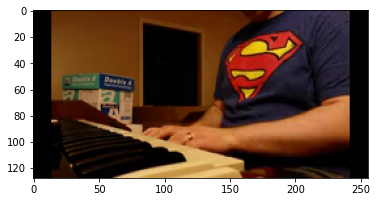

In [5]:
imshow(sample["mp4"][0][0])
sample["mp4"][0].shape

Let's look at 36 frames from the video.

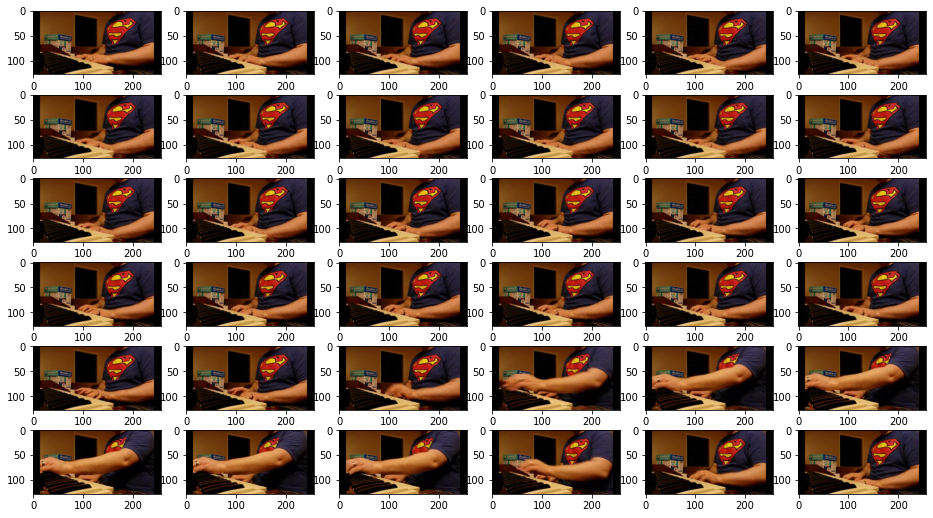

In [6]:
figsize(16, 9)
n = len(sample["mp4"][0])
for i, f in enumerate(sample["mp4"][0][0:n-36:n//36]):
    subplot(6, 6, i+1)
    imshow(f)

# Falling Things Data

Clips in the YT8m dataset are stored as video files. In many applications, videos are actually stored as sequences of individual images.

The `alling-things-3frames-shuffled` dataset provides an example of this (it is derived from the Falling Things dataset).

In [19]:
!curl -L -s https://storage.googleapis.com/nvdata-fallingthings/clips/falling-things-3frames-shuffled-000000.tar | tar tvf - | head

-rwxr-xr-x bigdata/bigdata 278214 2020-09-03 07:52 fat/mixed/kitedemo_3/001166/frame.000001.image.jpg
-rwxr-xr-x bigdata/bigdata 201386 2020-09-03 07:52 fat/mixed/kitedemo_3/001166/frame.000002.depth.png
-rwxr-xr-x bigdata/bigdata 242860 2020-09-03 07:52 fat/mixed/kitedemo_3/001166/frame.000002.image.jpg
-rwxr-xr-x bigdata/bigdata 117790 2020-09-03 07:52 fat/mixed/kitedemo_3/001166/frame.000000.depth.png
-rwxr-xr-x bigdata/bigdata 206575 2020-09-03 07:52 fat/mixed/kitedemo_3/001166/frame.000000.image.jpg
-rwxr-xr-x bigdata/bigdata 199519 2020-09-03 07:52 fat/mixed/kitedemo_3/001166/frame.000001.depth.png
-rwxr-xr-x bigdata/bigdata 362315 2020-09-03 07:52 fat/mixed/kitedemo_4/000716/frame.000001.depth.png
-rwxr-xr-x bigdata/bigdata 289780 2020-09-03 07:52 fat/mixed/kitedemo_4/000716/frame.000001.image.jpg
-rwxr-xr-x bigdata/bigdata 515337 2020-09-03 07:52 fat/mixed/kitedemo_4/000716/frame.000002.depth.png
-rwxr-xr-x bigdata/bigdata 344835 2020-09-03 07:52 fat/mixed/kitedemo_4/000716/fra

As you can see, each clip is stored as a collection of images with the same basename (`.../frame` in this case, though there is nothing special about that), and then a numbered sequence of image files (again, this is just a convention, albeit a convenient one).

We can open this like any other WebDataset.

In [22]:
fat_3frames = "https://storage.googleapis.com/nvdata-fallingthings/clips/falling-things-3frames-shuffled-{000000..000004}.tar"

ds = wds.Dataset(fat_3frames).decode()

for sample in ds:
    break
    
sample.keys()

dict_keys(['__key__', '000001.image.jpg', '000002.depth.png', '000002.image.jpg', '000000.depth.png', '000000.image.jpg', '000001.depth.png'])

To reassemble the images into a 4D numerical array, we just loop through the frame numbers and combine the images we get.

In [17]:
images = np.array([sample[f"{i:06d}.image.jpg"] for i in range(3)])
print(images.shape)

(3, 540, 960, 3)


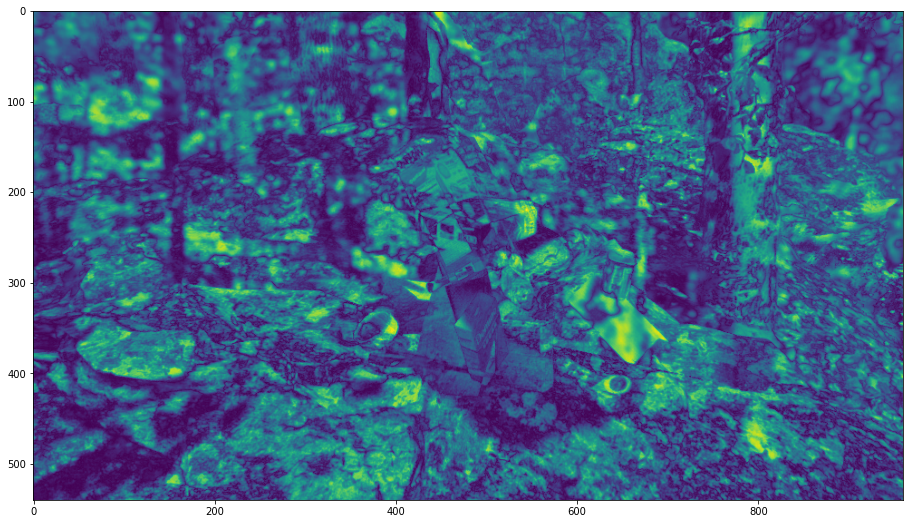

In [18]:
imshow(np.amax(np.abs(images[1]-images[0]), axis=2))

If you like, you can do this directly in the `Dataset` class using the `.map` method.

In [23]:
def assemble_frames(sample):
    images = np.array([sample[f"{i:06d}.image.jpg"] for i in range(3)])
    depths = np.array([sample[f"{i:06d}.depth.png"] for i in range(3)])
    return images, depths

ds = wds.Dataset(fat_3frames).decode().map(assemble_frames)

for images, depths in ds:
    break
    
print(images.shape, depths.shape)

(3, 540, 960, 3) (3, 540, 960, 3)
